In [5]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, "..") 
from src.data import make_dataset
from src.visualization import visualize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data exploratie

In dit onderzoek is uitgegaan van een beperkte reeks van staatsobligaties. er zijn op de Europese bondmarkt zeer veel verschillende obligaties beschikbaar. In dit onderzoek is alleen uitgegaan van staatsobligaties. Staatsobligaties zijn in tegenstelling tot aandelen wel goed vergelijkbaar. wanneer we kijken naar het prijsverloop zien we dan ook een sterke correlatie tussen de verschillende obligaties. Mogelijk kan het koersverloop van andere obligaties daarom gebruikt worden als voorspeller voor de prijsontwikkeling van een specifieke obligatie.

In [6]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

In [7]:
df_bonds = make_dataset.read_pkl('bonds', colab = IS_COLAB)

2022-01-28 17:25:53.667 | INFO     | src.data.make_dataset:read_pkl:402 - Load preprocessed bonds data


In [22]:
df_bonds.head()

,ccy,country,bond_ext_name,issue_dt,first_coupon_date,mature_dt,isin,issuer_name,coupon_frq,coupon,tot_issue,cfi_code,issue_rating,bond_duration,issue
0,EUR,Netherlands,Nederland 4.00% 09-2019,2009-02-13,2009-07-15,2019-07-15,NL0009086115,STAAT DER NEDERLANDEN,ANNUAL,4.000,5000.0,DBFTFN,AAA,3804,NL0009086115 Netherlands 4.00% 09-2019
1,NLG,Austria,Austria 6.25% 94-2024,1994-02-28,1995-02-28,2024-02-28,NL0000133924,AUSTRIA,ANNUAL,6.250,1000.0,DBFTXB,AA+,10957,NL0000133924 Austria 6.25% 94-2024
2,EUR,Netherlands,Nederland 2.50% 12-2033,2012-03-09,2013-01-15,2033-01-15,NL0010071189,STAAT DER NEDERLANDEN,ANNUAL,2.500,4160.0,DBFXXN,AAA,7617,NL0010071189 Netherlands 2.50% 12-2033
5,USD,United States,US GOVT 6.125% 99-2029,1999-08-15,1999-08-15,2029-08-15,US912810FJ26,UNITED STATES TREASURY,SEMI ANNUAL,6.125,11179.0,DBFTFR,AAA,10958,US912810FJ26 United States GOVT 6.125% 99-2029
7,USD,United States,US GOVT 6.250% 00-2030,2000-02-15,2000-05-15,2030-05-15,US912810FM54,UNITED STATES TREASURY,SEMI ANNUAL,6.250,17043.0,DTFTFR,AAA,11047,US912810FM54 United States GOVT 6.250% 00-2030


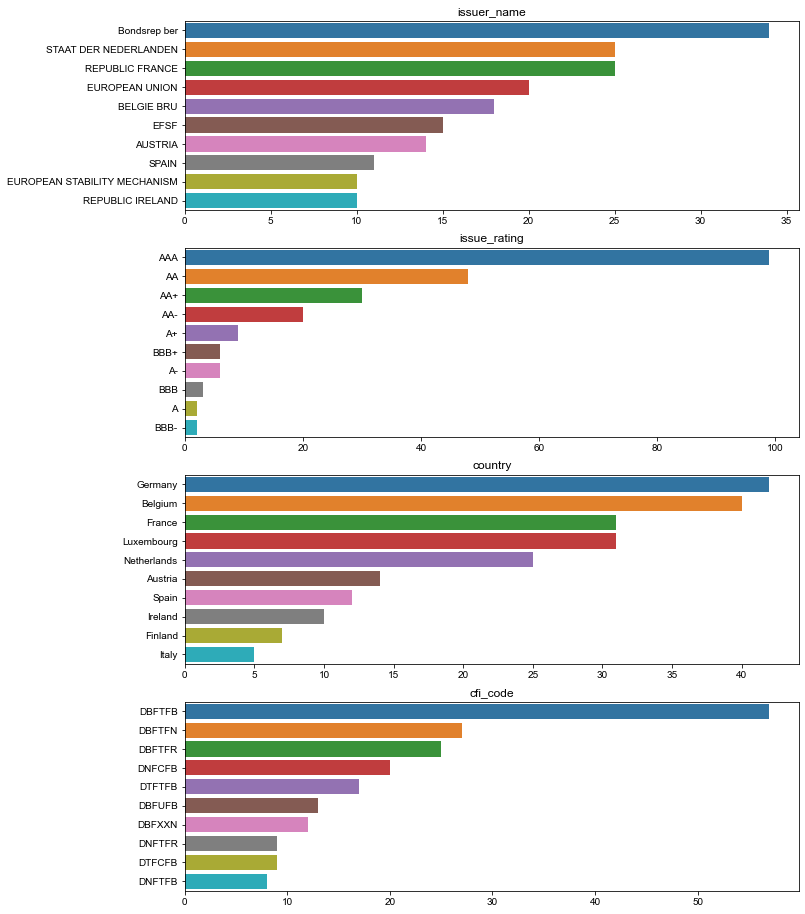

In [23]:
visualize.countplot(
    data = df_bonds, 
    x = ['issuer_name', 'issue_rating','country','cfi_code'], 
    subplots = True, 
    ncols = 1, 
    other_category = True, 
    figsize = (11 , 16)
)
plt.show()

# Prijzen


In de onderzoek is uitgegaan van dagelijkse slotprijzen van obligaties. De prijzen zijn tot stand gekomen door het middelen van de prijzen zoals die zijn aangeboden door een aantal brokers. Niet alle brokers geven altijd goede prijzen af voor alle obligaties.
Door de outliers te verwijderen en de prijzen van de overige aanbieders te middelen is op dagbasis een goede prijsindicatie beschikbaar.

In [24]:
df_price = make_dataset.read_pkl('price')
df_price.head()

2022-01-28 12:33:30.835 | INFO     | src.data.make_dataset:read_pkl:356 - Load preprocessed price data


,reference_identifier,ccy,rate_dt,mid,lastday
0,DE0001135143,EUR,2010-12-17,136.760,2010-12-31
1,NL0000102275,EUR,2010-12-17,103.390,2010-12-31
2,DE0001135424,EUR,2010-12-17,95.453,2010-12-31
3,NL0009446418,EUR,2010-12-17,102.690,2010-12-31
4,NL0000102234,EUR,2010-12-17,106.220,2010-12-31


Wanneer we kijken naar de distributie van de obligatieprijzen zien we dat de meeste obligaties boven par (100) zijn geprijst. Dat is verkaarbaar omdat in de economie de rente al geruime tijd dalend is.De waarde van eerder uitgegeven obligaties stijgt hierdoor.

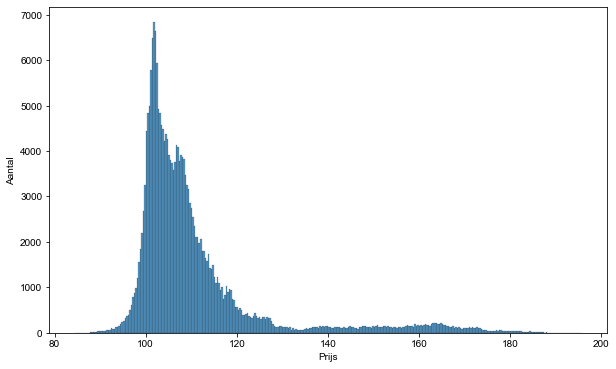

In [25]:
visualize.distribution(df_price,x = 'mid')
plt.show()

Voor het onderzoek richten we ons in eerste instantie op Nederlandse staatsobligaties met een looptijd van 10 jaar. Voor bijna ieder jaar is er een uitgifte van een 10 jaars vastrente obligatie. We zien dat de bond prijs gerelateerd is aan de hoogte van de coupon en de resterende looptijd. 

In [26]:
df_bp = make_dataset.read_pkl('bp')

2022-01-28 12:33:46.194 | INFO     | src.data.make_dataset:read_pkl:356 - Load preprocessed bp data


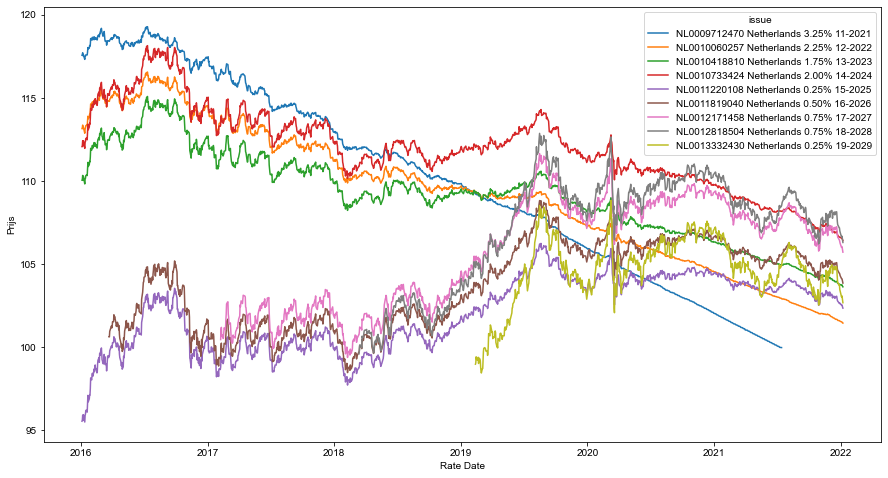

In [28]:
# Select 10 year NL bonds, data from 2016
df_bp_10y = df_bp.loc[  ( df_bp['bond_duration'] > 3650 ) & \
                        ( df_bp['bond_duration'] < 4000 ) ]
df_bp_10y = df_bp_10y.sort_values( by = ['country','mature_dt'] )

filter =    ( df_bp_10y['country'] == 'Netherlands' ) & \
            ( df_bp_10y['coupon'] > 0 ) & \
            ( df_bp_10y['rate_dt'] > '1-jan-2016' )       
df_nl_10y = df_bp_10y.loc[filter]

visualize.lineplot(
    df_nl_10y, 
    x = 'rate_dt', 
    x_label = 'Rate Date',
    y = 'mid', 
    y_label = 'Prijs',
    hue = 'issue', 
    figsize=(15,8))
plt.show()

De hoogte van de bondprijs is ook gecorreleerd met de hoogte van de coupon. Dit heeft uiteraard te maken met het moment van uitgifte van de obligaties. Een obligatie die was uitgegeven in een tijd waar hogere rentes werden betaald zal een hogere couponrente kennen. Deze obligatie is in de huidige markt meer waard, doordat de belegger meer rente krijgt op deze obligaties dan dat momenteel op de markt verkrijgbaar is. Hierdoor zal een premie worden betaald voor een obligatie met een hogere couponrente.

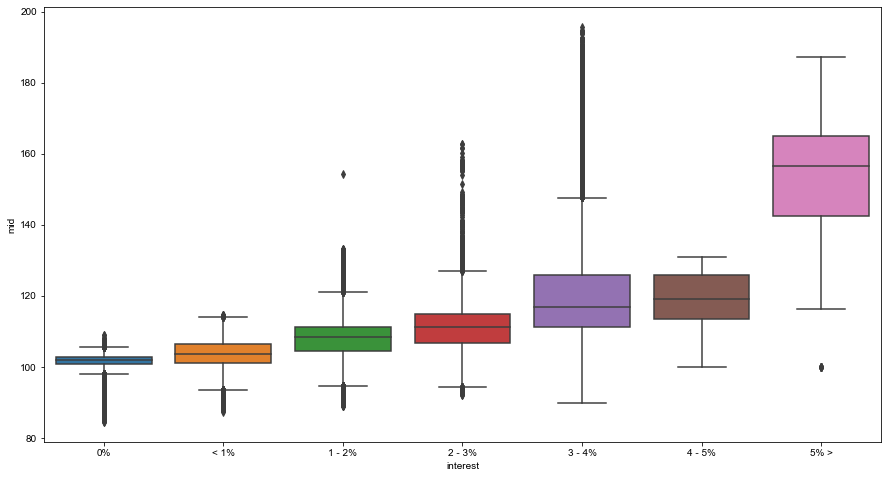

In [29]:
df_bp =df_bp.assign(interest = pd.cut(df_bp["coupon"], [-1,0.001,1,2,3,4,5,10], 
                        labels=['0%', '< 1%', '1 - 2%','2 - 3%', '3 - 4%','4 - 5%', '5% >']))
visualize.boxplot(data = df_bp, x= 'interest', y = 'mid', figsize=(15,8))
plt.show()

We kunnen ook bonds vergelijken met een zelfde resterende looptijd. Het koersverloop wordt dan met name verklaard door het kredietrisico van de issuer en de coupon rente. In onderstaand plaatje zien we dat de markt in 2020 tijdelijk wat minder vertrouwen leek te hebben in Italiaans schuldpapier.

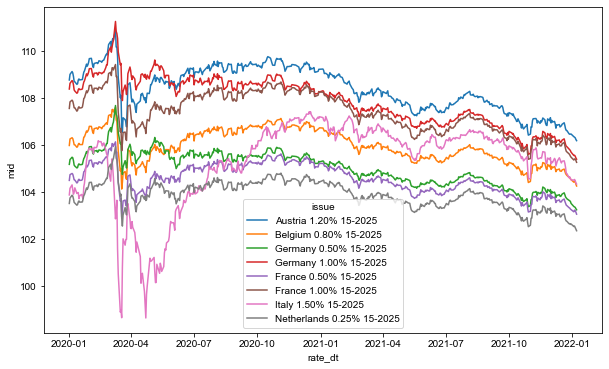

In [30]:
df_mature_2025 = df_bp.loc[( df_bp['mature_dt'].dt.year == 2025 )]
filter =    ( df_mature_2025['coupon'] > 0 ) & \
            ( df_bp_10y['rate_dt'] > '1-jan-2020' )                            
df_mature_2025 = df_mature_2025.loc[filter]
df_mature_2025['issue'] = df_mature_2025['country'] + ' ' + df_mature_2025['bond_ext_name'].str.split(n=1).str[1]

visualize.lineplot(data = df_mature_2025, x = 'rate_dt', y = 'mid', hue = 'issue')
plt.show()

Daarnaast kunnen we ook kijken naar de rating van een obligatie. De rating in onderstaande visualisatie is een combinatie van de rating zoals deze is afgegeven door de de drie grote rating agencies (Fitch, Moodies en S&P). De rating van de obligatie lijkt niet zo veel invloed te hebben op de bondprijs.

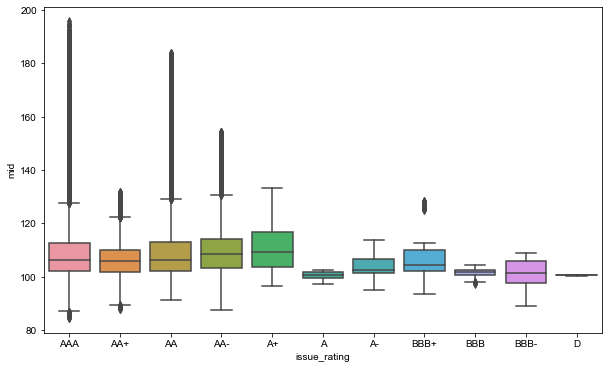

In [31]:
visualize.boxplot(data = df_bp, x= 'issue_rating', y = 'mid', order=["AAA", "AA+","AA","AA-","A+","A","A-","BBB+","BBB","BBB-","D"])
plt.show()

# Rente Curve

De rentecurve wordt samengesteld door de prijzen van staatsobligaties met verschillende looptijden samen te voegen en te extrapoleren. De rente curve (yield curve) is de benchmark waar tegen de te ontvagen kasstromen worden verdisconteerd. De marktwaarde van de bond is negatief gecorreleerd met de ontwikkeling van de rente. In onderstaande grafiek vergelijken we het verloop van een Nederlandse staatsobligatie die loopt tot 2025, met de 3 jaars rente.

In [32]:
df_yield = make_dataset.read_pkl('yield')

2022-01-28 12:34:31.395 | INFO     | src.data.make_dataset:read_pkl:356 - Load preprocessed yield data


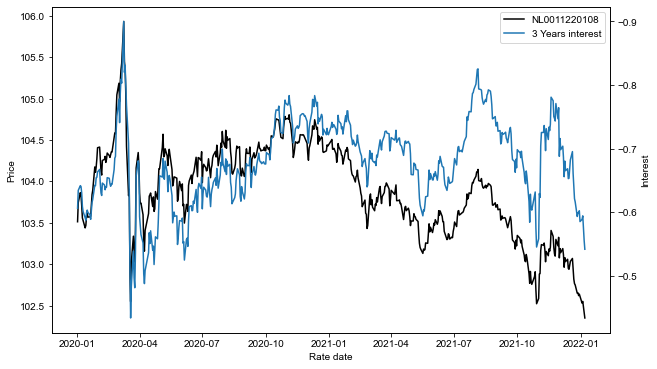

In [33]:
df_yield_nl = df_yield[ (df_yield['country']=='Netherlands' ) & \
                        ( df_yield['rate_dt']>='1-jan-2020' ) ]
df_yield_nl = df_yield_nl[df_yield_nl['timeband'].isin(['3 YEARS'])]

df = df_bp[ ( df_bp['isin'] == "NL0011220108" ) & \
            ( df_bp['rate_dt'] >= '1-jan-2020') ]

visualize.lineplot2(
    data = df, 
    data2 = df_yield_nl, 
    x = 'rate_dt', 
    y = 'mid',
    x_label = 'Rate date',
    y_label = 'Price',
    y2_label = 'Interest',
    label = 'NL0011220108',
    y2 = 'mid',
    label2 = '3 Years interest',
    invert_yaxis2 = True
    )
plt.show()

Een feature voor het voorspellen van de koersontwikkeling van de obligatiemarkt die vanuit de literatuur wordt aangedragen is de 'term spread'. Dit is het verschil tussen korte en lange rente. We zien in onderstaand plaatje dat het verschil in korte en langer rente tot 2019 sterk terug liep.

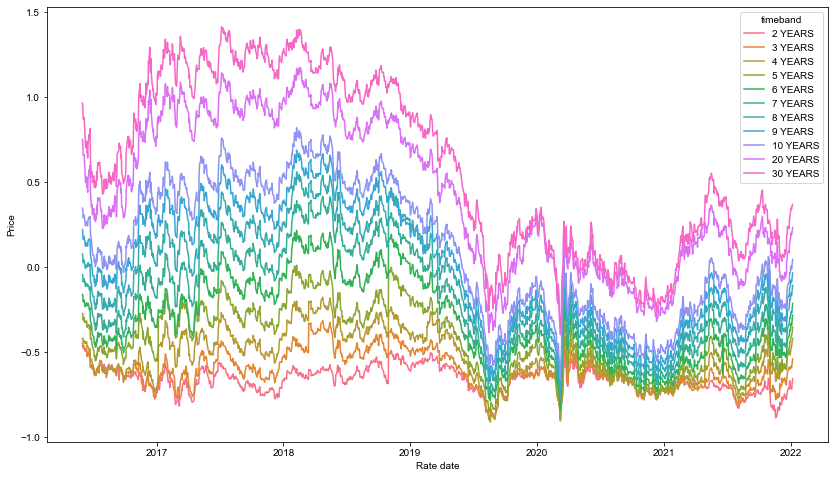

In [34]:
df_yield_NL_2016 = df_yield[ ( df_yield['rate_dt'] > '1-jan-2016' ) & \
                             ( df_yield['country']== 'Netherlands' ) ]

hue_order = sorted(df_yield_NL_2016['timeband'].unique(), key = lambda x: int(x[0:2]))
visualize.lineplot(
    df_yield_NL_2016, 
    x = 'rate_dt', 
    x_label = 'Rate date',
    y = 'mid', 
    y_label = 'Price',
    hue = 'timeband', 
    hue_order = hue_order,
    figsize = (14,8))
plt.show()


Inflation

De rente is theoretisch gecorreleerd aan de inflatie verwachting. In de praktijk is deze correlatie niet altijd evident. Ook is het niet duidelijk of de bondprijzen worden gevormd door de lnflatieverwachting, of omgekeerd de inflatie wordt afgeleid uit stijgende prijzen voor staatsobligaties. In dit onderzoek is uitgegaan van dagelijkse inflatiegegevens afgeleidt uit de prijzen van inflatieswaps. Inflatieswaps worden onder andere door pensioenfondsen gebruikt om inflatie risico's te hedgen. We zien onder andere dat recent de korte termijn inflatieverwachting hard stijgt. Bij de analyse van de modellen met meer features ga ik nader in op de relatie tussen inflatie en bondprijzen.

In [35]:
df_inflation = make_dataset.read_pkl('inflation')

2022-01-28 12:34:57.660 | INFO     | src.data.make_dataset:read_pkl:356 - Load preprocessed inflation data


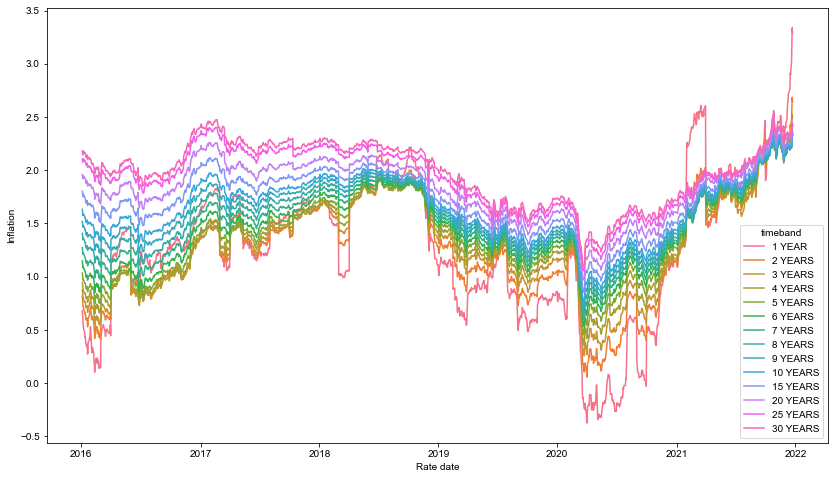

In [36]:
df_inflation_Germany = df_inflation[ ( df_inflation['rate_dt'] > '1-jan-2016' ) & \
                                     ( df_inflation['country']=='Germany') ]
hue_order = sorted(df_inflation_Germany['timeband'].unique(), key = lambda x: int(x[0:2]))
visualize.lineplot(
    df_inflation_Germany, 
    x = 'rate_dt', 
    x_label = 'Rate date',
    y = 'inflation', 
    y_label = 'Inflation',
    hue = 'timeband', 
    hue_order=hue_order,
    figsize = (14,8))
plt.show()